In [1]:
#system libraries
import os
import sys
import platform
from glob import glob
from pathlib import Path
import gc

#common libraries
import numpy as np
import pandas as pd
from jinja2.filters import K

from matplotlib import pyplot as plt

#image preprocessing
import cv2

#tensorflow
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Input, Flatten,
                                    Dropout, UpSampling2D, GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

#sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import load_files

#balancing dataset
from imblearn.over_sampling import SMOTE


2023-09-03 16:53:00.699139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(f'Python platform: {platform.platform()}')
print(f'Tensorflow version: {tf.__version__}')
#print(f"Keras version {keras.__version__}")
print()
print(f'System version: {sys.version}')
# print(f'Panda version: {pd.__version__}')
# print(f'Scikit-learn: {sk.__version__}')
gpu = len(tf.config.list_physical_devices("gpu")) > 0
print("GPU is ", "available" if gpu else "NOT AVAILABLE")

Python platform: Linux-6.2.0-31-generic-x86_64-with-glibc2.35
Tensorflow version: 2.12.0

System version: 3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]
GPU is  NOT AVAILABLE


In [13]:
basedir = Path(os.getcwd())
images_dir = Path(os.path.join(basedir, 'FaceShape Dataset'))
train_dir = Path(os.path.join(basedir, 'FaceShape Dataset/training_set'))
test_dir = Path(os.path.join(basedir, 'FaceShape Dataset/testing_set'))

In [9]:
# train_dir = os.path.join('/FaceShape Dataset', 'training_set')
# test_dir = os.path.join('/FaceShape Dataset', 'testing_set')

In [14]:
def load_as_dataframe(path, target_shape=(224, 224)):
    data = load_files(path)
    face_files = np.array(data['filenames'])
    face_targets = np.array(data['target'])

    images, labels = [], []
    for file, target in zip(face_files, face_targets):
        img = cv2.imread(file)
        if img is not None:
            img_resized = cv2.resize(img, target_shape)
            images.append(img_resized)
            labels.append(target)
        else:
            print(f"Failed to load image at path: {file}")

    df = pd.DataFrame({
        'images': images,
        'faceshape': labels
    })

    return df

In [15]:
# Load datasets
df_train = load_as_dataframe(train_dir)
df_test = load_as_dataframe(test_dir)

Premature end of JPEG file
Premature end of JPEG file


In [ ]:
# Prepare data for SMOTE
X_images = np.array(df_train['images'].tolist()).reshape(len(df_train), -1)
y_matched = df_train['faceshape'].values

In [7]:
del df_train
gc.collect()

NameError: name 'df_train' is not defined

In [9]:
X_images_test = np.array(df_test['images'].tolist()).reshape(len(df_test), -1)
y_matched_test = df_test['faceshape'].values

In [10]:
del df_test
import gc
gc.collect()

0

In [10]:
# SMOTE
sm = SMOTE(random_state=42)
X_smote_train, y_smote_train = sm.fit_resample(X_images, y_matched)
X_smote_test, y_smote_test = sm.fit_resample(X_images_test, y_matched_test)

In [11]:
print(X_images.shape)
print(y_matched.shape)

(3250, 150528)
(3250,)


In [12]:
print(df_train['faceshape'].unique())

[2 3 0 1 4]


In [13]:
print(df_train['faceshape'].isna().sum())

0


In [ ]:
del X_images, y_matched
gc.collect()

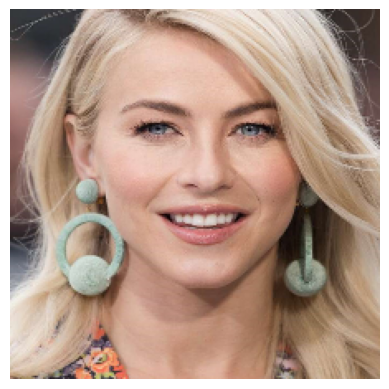

In [14]:
image_to_display = df_train["images"].iloc[0]

# Display the image
plt.imshow(image_to_display[..., ::-1])  # Convert BGR to RGB format for displaying
plt.axis('off')  # To hide axis values
plt.show()

In [19]:
face_type = [item[52:-1] for item in sorted(glob('/OriginalDataset/training_set/*/'))]
face_type

[]

In [16]:
df_train.head()

,images,faceshape
0,"[[[59, 56, 52], [59, 56, 52], [61, 58, 54], [6...",2
1,"[[[202, 194, 205], [162, 154, 165], [184, 176,...",2
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",3
3,"[[[113, 18, 98], [113, 18, 98], [113, 18, 98],...",3
4,"[[[84, 123, 175], [89, 125, 175], [94, 128, 17...",0


In [17]:
df_train.groupby('faceshape').count()

,images
faceshape,
0,800
1,799
2,800
3,800
4,51


In [18]:
df_test.groupby('faceshape').count()

,images
faceshape,
0,200
1,200
2,200
3,200
4,200


In [22]:
def check_image_dimensions(df):
    unique_shapes = set()
    for idx, row in df.iterrows():
        img = cv2.imread(row['images'])
        if img is not None:
            unique_shapes.add(img.shape)
        else:
            print(f"Failed to load image at path: {row['images']}")
    return unique_shapes

print(check_image_dimensions(df_train))

TypeError: Can't convert object of type 'numpy.ndarray' to 'str' for 'filename'

In [23]:
y_smote_df_train = pd.DataFrame(data=y_smote_train, columns=['faceshape'])
faceshapes_df_train = y_smote_df_train.groupby('faceshape').size().reset_index(name='count')
print(faceshapes_df_train)

   faceshape  count
0          0    800
1          1    800
2          2    800
3          3    800
4          4    800


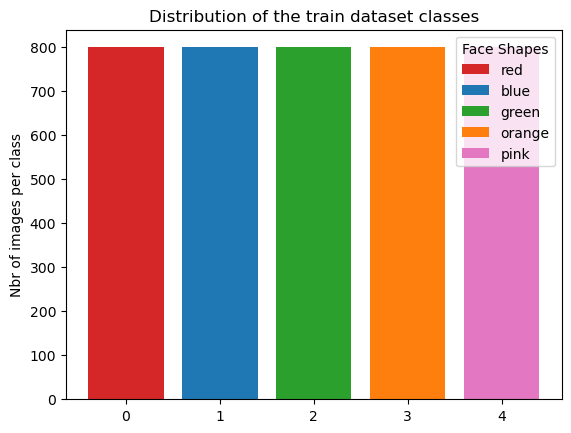

In [28]:
fig, ax = plt.subplots()

bar_labels = ['red', 'blue', 'green', 'orange','pink' ]
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:pink']

ax.bar(faceshapes_df_train['faceshape'], faceshapes_df_train['count'], label=bar_labels, color=bar_colors)

ax.set_ylabel('Nbr of images per class')
ax.set_title('Distribution of the train dataset classes')
ax.legend(title='Face Shapes')

## EDA

In [29]:
X_smote_i = X_smote_train.reshape((-1, *(224,224), 3))
X_smote_images = X_smote_i / 255.0
y_smote_categorical = tf.keras.utils.to_categorical(y_smote_train, num_classes=5)

In [30]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [88]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_smote_images, y_smote_categorical))
train_dataset = train_dataset.shuffle(1024)


In [89]:
DATASET_SIZE = len(train_dataset)
train_size = int(0.7 * DATASET_SIZE)

In [90]:
 len(train_dataset)

4000

In [91]:
train_dataset = train_dataset.take(int(0.7*len(train_dataset)))
val_dataset = train_dataset.skip(int(0.7*len(train_dataset)))
print(len(val_dataset))

841


In [92]:
train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [103]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [82]:
def create_model():
  inputs = Input(shape=(224, 224, 3))
  x1 = data_augmentation(inputs)
  x2 = preprocess_input(x1)
  base_model_layer = base_model(x2, training=False)
  pooling_layer = GlobalAveragePooling2D()(base_model_layer)
  dropout_layer = Dropout(0.1)(pooling_layer)
  Layer_1 = Dense(512, activation='relu')(dropout_layer)
  outputs = Dense(5, activation='softmax')(Layer_1)
  model = Model(inputs, outputs)
  return model

In [83]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

In [84]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [85]:
preprocess_input = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## MOBILENETV2 model feature extraction

In [86]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [93]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-08-31 17:25:16.005990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [4000,5]
	 [[{{node Placeholder/_1}}]]
2023-08-31 17:25:16.006346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [4000,5]
	 [[{{node Placeholder/_1}}]]


(32, 7, 7, 1280)


In [62]:
label_batch

<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [63]:
image_batch

<tf.Tensor: shape=(32, 224, 224, 3), dtype=float64, numpy=
array([[[[0.89411765, 0.8627451 , 0.82352941],
         [0.89411765, 0.85882353, 0.82352941],
         [0.89803922, 0.8627451 , 0.82745098],
         ...,
         [0.85882353, 0.82352941, 0.77254902],
         [0.85882353, 0.82352941, 0.77254902],
         [0.8627451 , 0.82745098, 0.77647059]],

        [[0.89803922, 0.8627451 , 0.82745098],
         [0.89803922, 0.8627451 , 0.82745098],
         [0.89803922, 0.86666667, 0.83137255],
         ...,
         [0.85490196, 0.81960784, 0.76862745],
         [0.85490196, 0.81960784, 0.76862745],
         [0.85490196, 0.81960784, 0.76862745]],

        [[0.90196078, 0.86666667, 0.83137255],
         [0.90196078, 0.86666667, 0.83137255],
         [0.90196078, 0.86666667, 0.83137255],
         ...,
         [0.85882353, 0.82352941, 0.77254902],
         [0.85882353, 0.82352941, 0.77254902],
         [0.8627451 , 0.82352941, 0.77254902]],

        ...,

        [[0.90980392, 0.87058824,

In [50]:
base_model.trainable = False

In [45]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [104]:
inputs = Input(shape=(224, 224, 3))
x1 = data_augmentation(inputs)
x2 = preprocess_input(x1)
base_model_layer = base_model(x2, training=False)
pooling_layer = GlobalAveragePooling2D()(base_model_layer)
dropout_layer = Dropout(0.1)(pooling_layer)
Layer_1 = Dense(512, activation='relu')(dropout_layer)
outputs = Dense(5, activation='softmax')(Layer_1)
model = Model(inputs, outputs)

In [105]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy',f1_m])

In [96]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0   

In [72]:
len(model.trainable_variables)

4

In [58]:
type(val_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [59]:
type(model)

keras.engine.functional.Functional

In [106]:
initial_epochs = 10

loss, accuracy, f1_m0 = model.evaluate(val_dataset)

27/27 [==============================] - 8s 243ms/step - loss: 2.0245 - accuracy: 0.1772 - f1_m: 0.1813


In [107]:
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))
print("initial f1 score: {:.2f}".format(f1_m0))

initial loss: 2.02
initial accuracy: 0.18
initial f1 score: 0.18


In [112]:
checkpointer_init = ModelCheckpoint(filepath='model1.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
history_init = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset,
                    callbacks = [checkpointer_init])

Epoch 1/10
88/88 [==============================] - ETA: 0s - loss: 1.6019 - accuracy: 0.2225 - f1_m: 0.0165
Epoch 1: val_accuracy improved from -inf to 0.19857, saving model to model1.hdf5
88/88 [==============================] - 254s 3s/step - loss: 1.6019 - accuracy: 0.2225 - f1_m: 0.0165 - val_loss: 1.6606 - val_accuracy: 0.1986 - val_f1_m: 0.0000e+00
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 1.5900 - accuracy: 0.2304 - f1_m: 0.0045
Epoch 2: val_accuracy improved from 0.19857 to 0.22117, saving model to model1.hdf5
88/88 [==============================] - 255s 3s/step - loss: 1.5900 - accuracy: 0.2304 - f1_m: 0.0045 - val_loss: 1.6245 - val_accuracy: 0.2212 - val_f1_m: 0.0000e+00
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 1.5708 - accuracy: 0.2232 - f1_m: 6.3131e-04
Epoch 3: val_accuracy did not improve from 0.22117
88/88 [==============================] - 252s 3s/step - loss: 1.5708 - accuracy: 0.2232 - f1_m: 6.3131e-04 - val_loss